In [1]:
%cd ../..

/home/d/PycharmProjects/protein_properties


In [2]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import random
import matplotlib as mpl
import os
import gc
from torch.utils.tensorboard import SummaryWriter
from datetime import date
mpl.rcParams['figure.dpi'] = 180

In [3]:
# hyper-parameters
# batch_size = 11
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# LSTM Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_layers, seq_len,num_classes=1):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.seq_len = seq_len

        self.bnn1 = nn.Linear(input_size, 32)
        self.bnn2 = nn.Linear(32,64)
        self.bnn3 = nn.Linear(64,64)
        self.bnn4 = nn.Linear(64,64)

        self.lstm1 = nn.LSTM(64, hidden_size1, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        self.bn_lstm1 = nn.BatchNorm1d(2*hidden_size1,device=device)  
        # self.lstm2 = nn.LSTM(2*hidden_size1, hidden_size2, num_layers, batch_first=True, bidirectional=True, dropout=0.5)
        # self.bn_lstm2 = nn.BatchNorm1d(2*hidden_size2,device=device)
        self.nn1 = nn.Linear(2*hidden_size1, 2*hidden_size1)
        self.nn2 = nn.Linear(2*hidden_size1, 512)
        self.nn3 = nn.Linear(512, 512)
        self.nn4 = nn.Linear(512, 256)
        self.nn5 = nn.Linear(256, 256)
        self.nn6 = nn.Linear(256, 128)
        self.nn7 = nn.Linear(128, 32)
        self.nn8 = nn.Linear(32, 1)

    
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.batch = nn.BatchNorm1d()
        self.drop = nn.Dropout(p=0.5)


        
    def forward(self, x, array_lengths):
        # Set initial hidden states (and cell states for LSTM)
        # print(x.size(0))
        inital_seq_len = x.size(1)
        x = Variable(x.float()).to(device)

        x = torch.reshape(x, (x.size(0)*x.size(1), x.size(2)))

        ## before nn
        out = self.bnn1(x)
        out = self.relu(out)
        out = self.bnn2(out)
        out = self.relu(out)
        out = self.bnn3(out)
        out = self.relu(out)
        out = self.bnn4(out)
        out = self.relu(out)

        ## reshaping again
        out = torch.reshape(out, (-1, inital_seq_len, out.size(1)))
        # print(out.size())
        # print(aaaaa)

        # out = torch.permute(out, (0,2,1))
        
        pack = nn.utils.rnn.pack_padded_sequence(out, array_lengths, batch_first=True, enforce_sorted=False)
        h0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        c0 = Variable(torch.zeros(2*self.num_layers, x.size(0), self.hidden_size1).to(device))
        h1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        c1 = Variable(torch.zeros(2*self.num_layers, self.hidden_size1, self.hidden_size2).to(device))
        
        # Forward propagate RNN
        out, _ = self.lstm1(pack, (h0,c0))
        del(h0)
        del(c0)
        # out, _ = self.lstm2(out, (h1,c1))
        gc.collect()
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        this_batch_len = unpacked.size(1)
        out = unpacked
        # print('before', out.size())
        out = torch.reshape(out, (out.size(0)*out.size(1), out.size(2)))

        ##nn
        out = self.nn1(out)
        out = self.relu(out)
        out = self.nn2(out)
        out = self.relu(out)
        out = self.nn3(out)
        out = self.relu(out)
        out = self.nn4(out)
        out = self.relu(out)
        out = self.nn5(out)
        out = self.relu(out)
        out = self.nn6(out)
        out = self.relu(out)
        out = self.nn7(out)
        out = self.relu(out)
        out = self.nn8(out)
        
        ## reshaping
        out = torch.reshape(out, (-1, this_batch_len, 1))
        # print(out.size()) 
        # print(aaaaa)   
        

        return out

In [5]:
epoch_check =98
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is',device)
input_size = 28
hidden_size1 = 512
hidden_size2 = 64
num_layers = 1
init_lr = 0.001
num_epochs = 400
seq_len = 500
model_test = RNN(input_size, hidden_size1, hidden_size2, num_layers, seq_len).to(device)
model_test_weights = torch.load('results/pandey_bfactor/35_all/epoch_'+ str(epoch_check) + '.pth', map_location='cuda')
model_test.load_state_dict(model_test_weights)
model_test.eval().to(device)
print(model_test)

Device is cuda


/home/d/PycharmProjects/protein_properties/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNN(
  (bnn1): Linear(in_features=28, out_features=32, bias=True)
  (bnn2): Linear(in_features=32, out_features=64, bias=True)
  (bnn3): Linear(in_features=64, out_features=64, bias=True)
  (bnn4): Linear(in_features=64, out_features=64, bias=True)
  (lstm1): LSTM(64, 512, batch_first=True, dropout=0.5, bidirectional=True)
  (bn_lstm1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nn1): Linear(in_features=1024, out_features=1024, bias=True)
  (nn2): Linear(in_features=1024, out_features=512, bias=True)
  (nn3): Linear(in_features=512, out_features=512, bias=True)
  (nn4): Linear(in_features=512, out_features=256, bias=True)
  (nn5): Linear(in_features=256, out_features=256, bias=True)
  (nn6): Linear(in_features=256, out_features=128, bias=True)
  (nn7): Linear(in_features=128, out_features=32, bias=True)
  (nn8): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
  (drop): Dropout(p=0.5, inplace=False)
)


In [6]:
x_test = np.load('x_test_35.npy', allow_pickle=True)
# dataset preparation
class BetaDataset(Dataset) :
    def __init__(self,x,y, n_samples) :
        # data loading
        self.x = x
        self.y = y 
        self.n_samples = n_samples
        
        
    def __getitem__(self,index) :
        return self.x[index], self.y[index]

    def __len__(self) :    
        return self.n_samples      

test_dataset = BetaDataset(x_test,x_test,np.shape(x_test)[0])


test_loader = DataLoader(dataset=test_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

print('Number of test data set', np.shape(x_test)[0])

Number of test data set 2442


In [7]:
x_test.squeeze()

array([ 5843,  1977, 37294, ..., 26925, 13220, 54934])

In [8]:

from math import nan
all_x = np.load('data/pandey_bfactor/x_61046' + '.npy', allow_pickle=True)
all_y = np.load('data/pandey_bfactor/y_61046' + '.npy', allow_pickle=True)


In [9]:
# remove zeros from the test set
b_dist = all_y[x_test.squeeze()].squeeze().reshape(-1,1)
b_dist = b_dist[b_dist != 0]

In [10]:
b_dist_our = np.load("data/pandey_bfactor/bfactor_y_clean.npy")

In [11]:
b_dist.shape

(654736,)

In [12]:
b_dist.mean(), b_dist_our.mean()

(6.87299919356843e-05, -1.7119804703347323e-18)

In [13]:
b_dist.var(), b_dist_our.var()

(0.999999995276188, 0.9999999999999999)

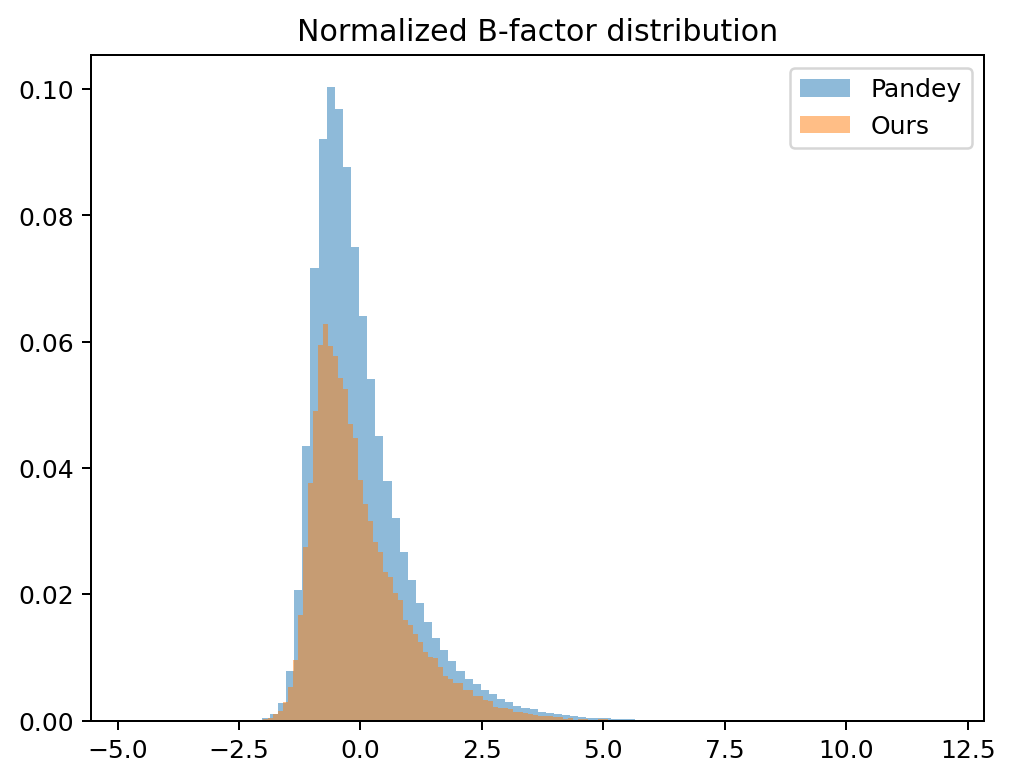

In [22]:
import matplotlib.pyplot as plt
plt.hist(b_dist, bins=100, alpha=0.5, label='Pandey', weights=np.ones(len(b_dist)) / len(b_dist))
plt.hist(b_dist_our, bins=100, alpha=0.5, label='Ours', weights=np.ones(len(b_dist_our)) / len(b_dist_our))
plt.legend(loc='upper right')
plt.title('Normalized B-factor distribution')
plt.show()

In [19]:
from scipy.stats import mannwhitneyu, permutation_test, ks_2samp
mannwhitneyu(b_dist, b_dist_our)


MannwhitneyuResult(statistic=19797037791.0, pvalue=0.04823537657999335)

In [20]:
ks_2samp(b_dist, b_dist_our)

KstestResult(statistic=0.01875922487551429, pvalue=2.803399053392999e-17)

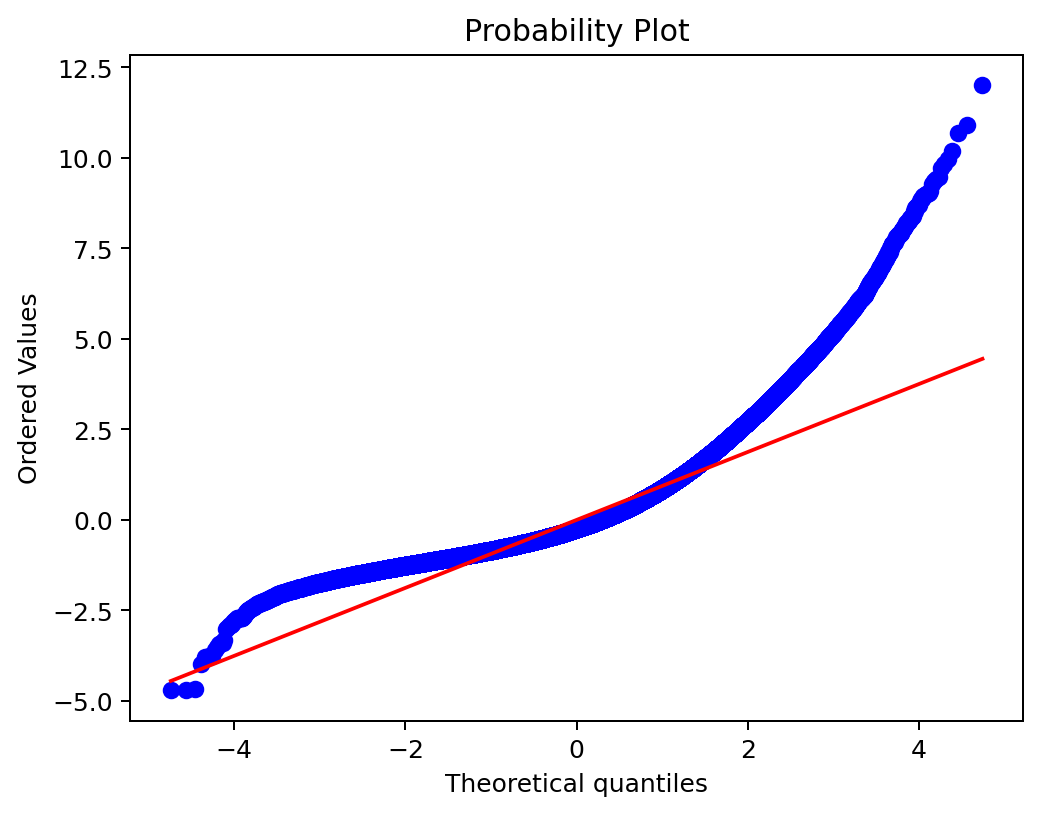

In [75]:
# qq plot
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(b_dist, dist="norm", plot=plt)
plt.show()

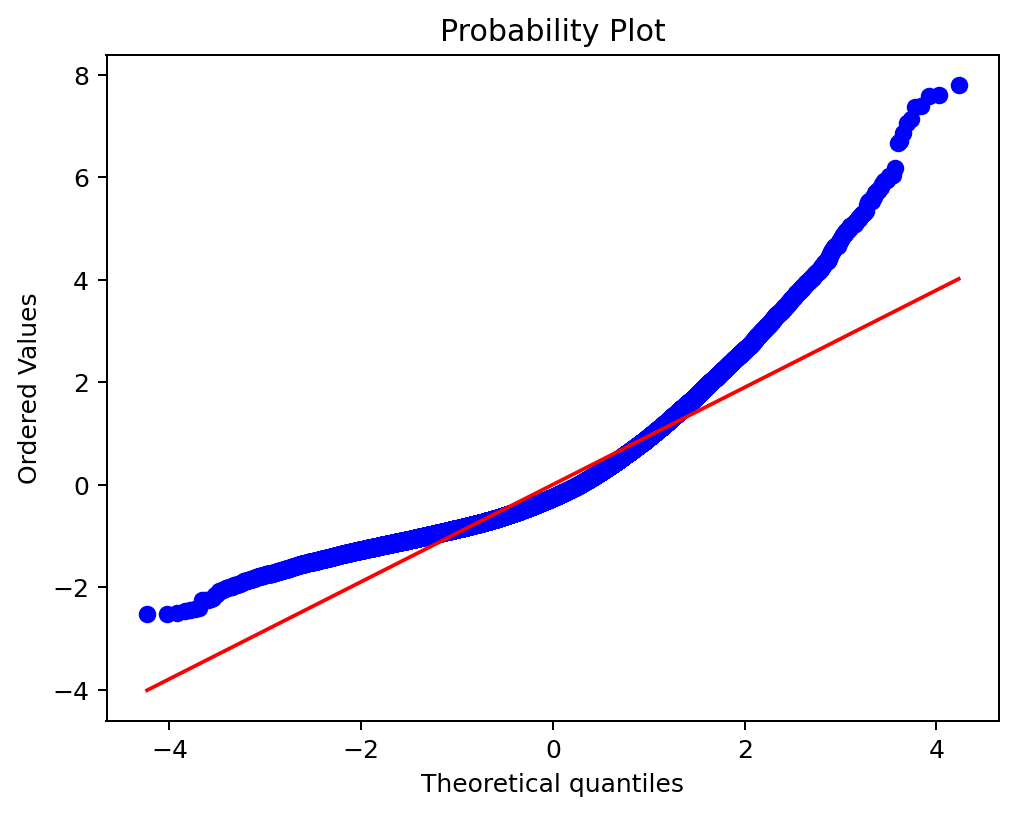

In [76]:
stats.probplot(b_dist_our, dist="norm", plot=plt)
plt.show()

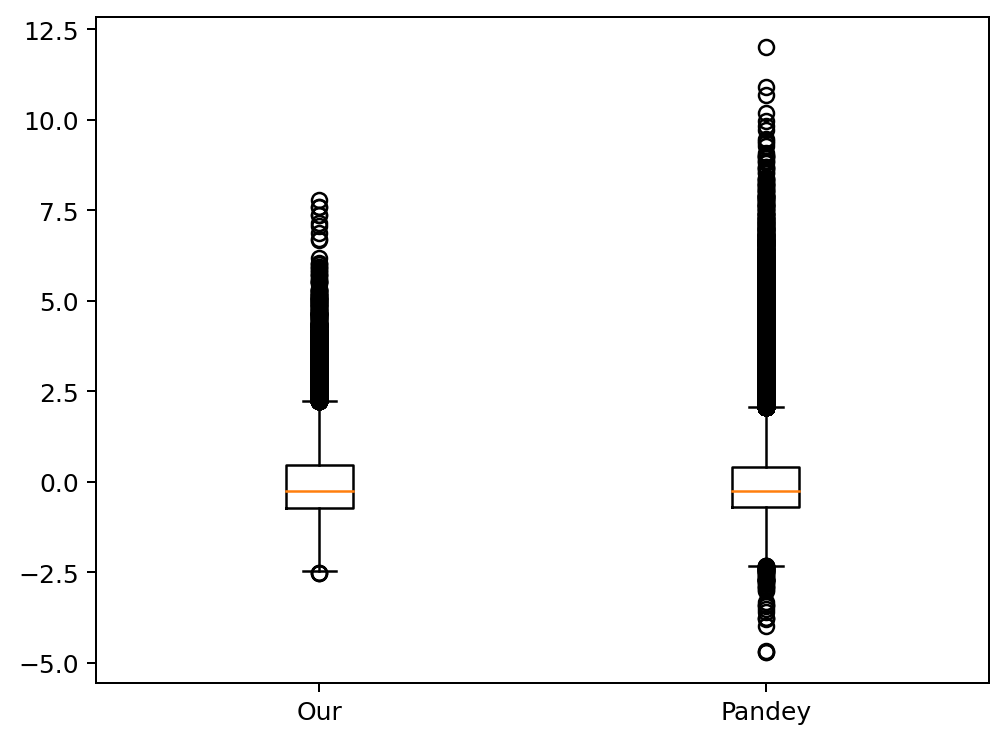

In [18]:
_ = plt.boxplot([b_dist_our, b_dist], labels=['Our', 'Pandey'])

In [26]:

# test_loader = test_loader[15:20,:]
p_beta = torch.zeros((1)).to(device)
a_beta = torch.zeros((1)).to(device)
collection_test = 0
avg_pearson_count = 0
avg_pearson = 0
avg_r2 = 0
count_all = 0
pearson_coeff = torch.zeros((np.shape(x_test)[0], ))
pearson_count = 0
ys = []
with torch.no_grad():
  for i, (parameters, no_req) in enumerate(test_loader):
    # parameters = parameters.to(device)
    input_x = torch.from_numpy(all_x[parameters,:,:]).to(device)
    output_y = torch.from_numpy(all_y[parameters,:,:]).to(device)
    input_x = torch.reshape(input_x, (input_x.size(0), input_x.size(2), input_x.size(3)))
    output_y = torch.reshape(output_y, (output_y.size(0), output_y.size(2), output_y.size(3)))
    ys.append(output_y.tolist())
    continue
    # forward pass  
    array_lengths = input_x[:,0,28]
    array_lengths = array_lengths.int()
    array_lengths = array_lengths.tolist()
    outputs = model_test(input_x[:,:,0:28], array_lengths)
    outputs = torch.reshape(outputs, (-1,int(max(array_lengths))) )
    output_y = torch.reshape(output_y[:,0:int(max(array_lengths)), 0], (-1,int(max(array_lengths))))
    
    outputs = outputs.T
    output_y = output_y.T
    
    


    for j in range(input_x.size()[0]):    
      prot_len = int(input_x[j,0,28].item())
      # print(prot_len)
      if prot_len != 0:
        a_beta = torch.cat((torch.flatten(output_y[0:prot_len,j].float()), a_beta.float()),0)
        p_beta = torch.cat((torch.flatten(outputs[0:prot_len,j].float()), p_beta.float()),0)
        
        if math.isnan(np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]):
          print('nan')
        else:
          # print(np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1])
          avg_pearson =  (avg_pearson*avg_pearson_count + np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1])/(avg_pearson_count+1)
          avg_r2 = (avg_r2*avg_pearson_count + r2_score(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu()))/(avg_pearson_count+1)
          avg_pearson_count += 1
          count_all = count_all + prot_len
          
          pearson_coeff[pearson_count,] = np.corrcoef(outputs[0:prot_len,j].cpu(), output_y[0:prot_len,j].cpu())[0,1]
          pearson_count += 1
          if pearson_coeff[pearson_count-1,] < 0.0:
            print(prot_len)
            # plt.plot(outputs[0:prot_len,j].cpu())
            # plt.plot(output_y[0:prot_len,j].cpu(), label='actual')
            # plt.legend()
            # plt.show()

    # print(torch.flatten(outputs.float()).size())

    # a_beta = torch.cat((torch.flatten(output_y.float()), a_beta.float()),0)
    # p_beta = torch.cat((torch.flatten(outputs.float()), p_beta.float()),0)

    
    del(input_x)
    del(output_y)
    gc.collect()

a_beta = a_beta[1:,]
p_beta = p_beta[1:,]

print('Total data collected', a_beta.size(0))
print('Total data predicted', p_beta.size(0))
# print('Total point should be',count_all)
print('Avgerage Pearson coefficient is', avg_pearson)
print('min', torch.min(pearson_coeff[0:pearson_count]))
print('max', torch.max(pearson_coeff[0:pearson_count]))

Total data collected 0
Total data predicted 0
Avgerage Pearson coefficient is 0


RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

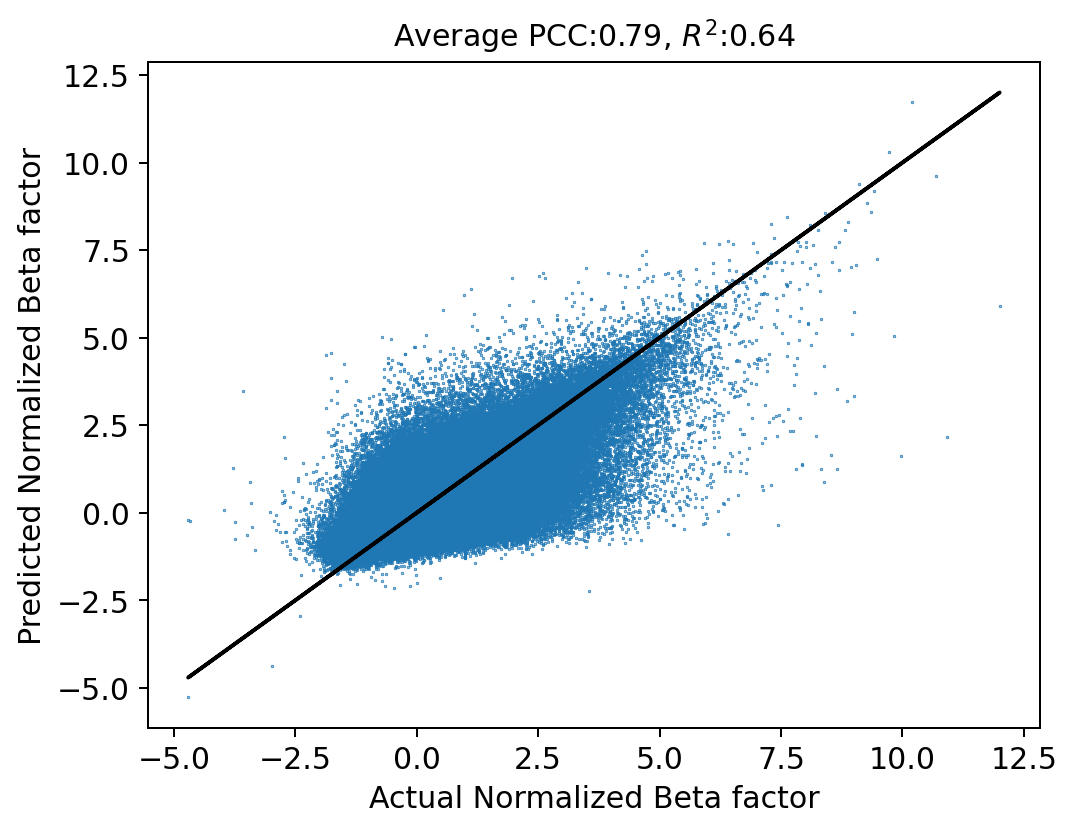

In [9]:
# combined = np.zeros((1,a_ebya))
with torch.no_grad():
    plt.figure(1)
    # plt.rcParams.update({'font.size': 16})
    plt.scatter(a_beta.cpu(), p_beta.cpu(), s=0.1)
    plt.plot(a_beta.cpu(), a_beta.cpu(),'k')
    plt.title(f'Average PCC:{round(avg_pearson,2)}, $R^2$:{round(r2_score(a_beta.cpu(), p_beta.cpu()),2)}')
    # plt.plot(p_beta[50000:100000].cpu())s
    plt.xlabel(r'Actual Normalized Beta factor', fontsize=12)
    plt.ylabel(r'Predicted Normalized Beta factor', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # plt.xlim([0,80])
    # plt.ylim([0,80])
    plt.show()

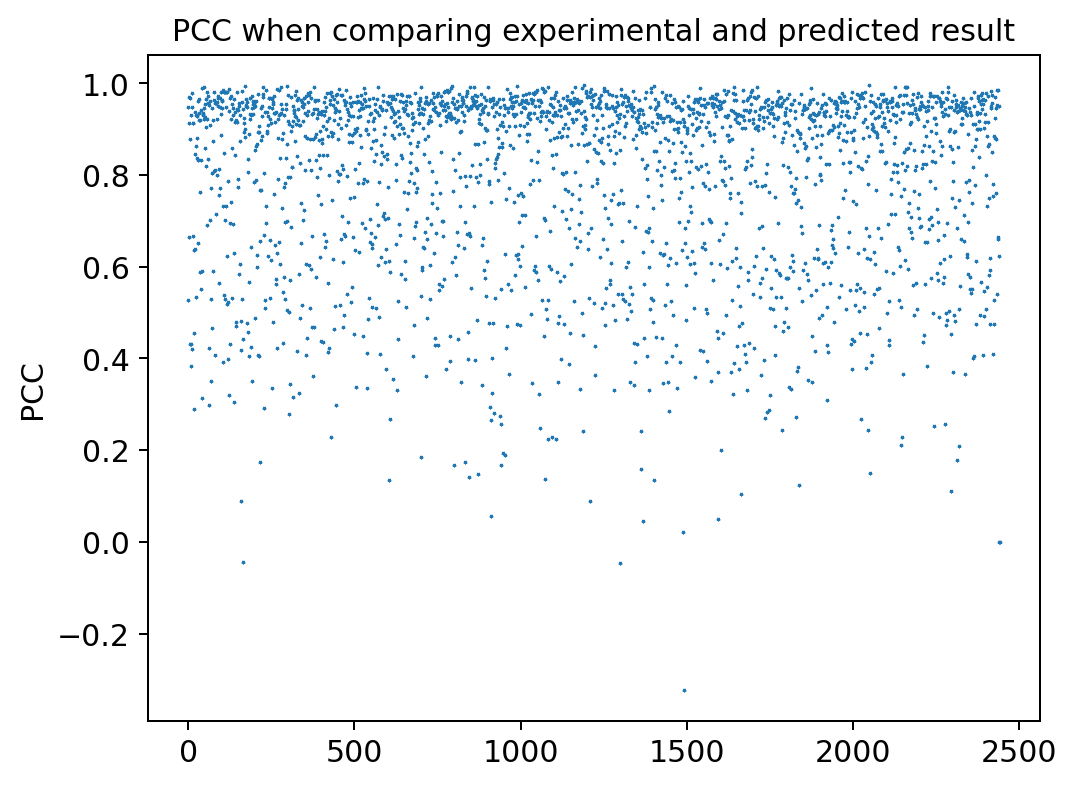

In [18]:
plt.figure(1)
# plt.rcParams.update({'font.size': 16})
plt.plot(pearson_coeff, '*', markersize=1)
# plt.title(f'Average Pearson Correlation Coefficient={round(avg_pearson,2)}', fontsize=12)
# plt.plot(p_beta[50000:100000].cpu())s
# plt.xlabel(r'Actual Normalized Beta factor', fontsize=12)
plt.title('PCC when comparing experimental and predicted result', fontsize=12)
plt.ylabel(r'PCC', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim([0,80])
# plt.ylim([0,80])
plt.show()

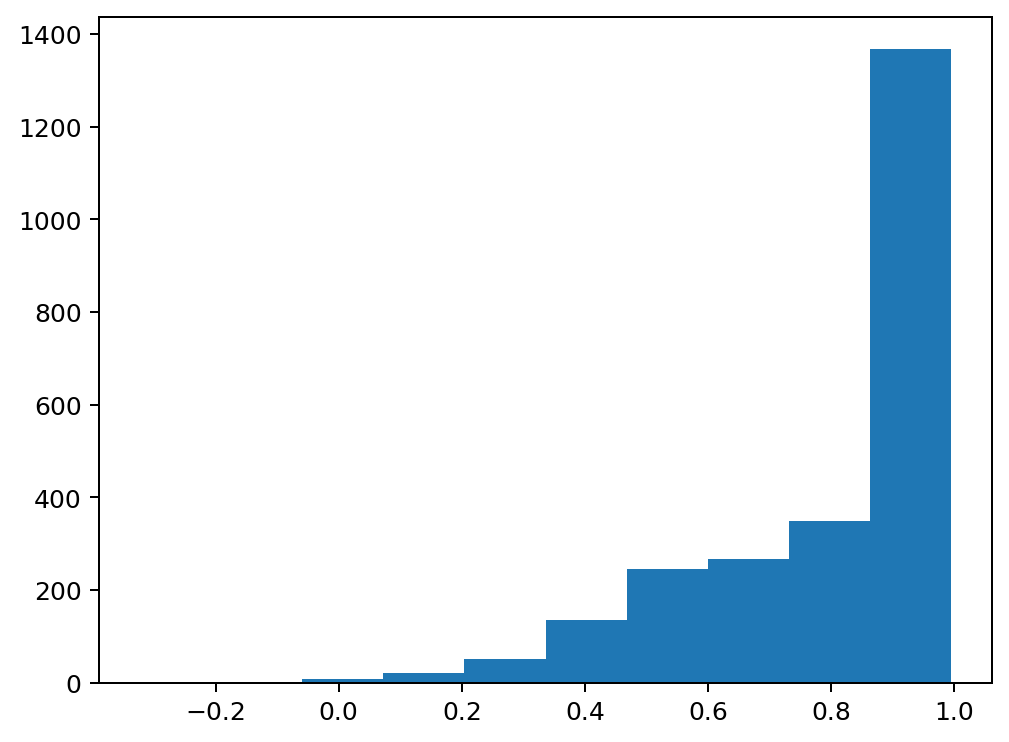

In [19]:
n, bins, patches = plt.hist(pearson_coeff, bins=10)
plt.show()